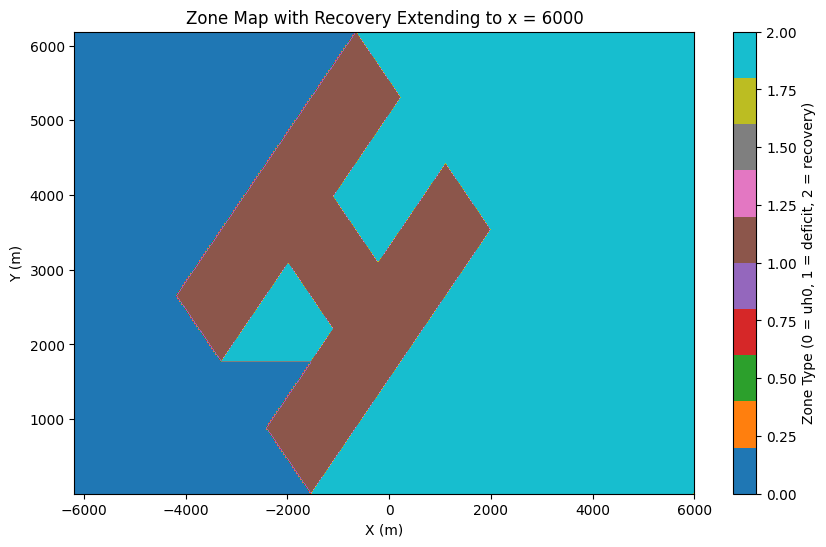

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

def create_wind_farm_mask(corner_points, resolution=10, rotation_degrees=0, mirror_axis=None, pre_park_buffer=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align downstream edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Shift entire farm forward by pre_park_buffer
    points[:, 0] += pre_park_buffer

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x bounds to include upstream buffer space
    min_x -= pre_park_buffer
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)  # Ensure x_range covers recovery area

    # Define resolution factors
    fine_resolution = resolution / 5

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# --- Define park shape and buffer ---
#corner_points = [(0, 0), (200, 0), (200, 100),(150, 100), (150, 50), (50, 50), (50, 100),(0, 100)]
#corner_points = [(0, 0), (300, 0), (300, 150), (0, 150)] # Rectangle
#corner_points = [(0, 0), (300, 0), (300, 100), (200, 100), (200, 50), (100, 50), (100, 100), (0, 100)] # U-shape
#corner_points = [(0, 0), (150, 0), (150, 50), (50, 50), (50, 150), (0, 150)] # L-shape
corner_points = [(0, 0), (200, 0), (200, 50), (125, 50), (125, 100), (200, 100), (200, 150), (0, 150), (0, 100), (75, 100), (75, 50), (0, 50)] # Hourglass
corner_points = [(x * 25, y * 25) for x, y in corner_points]
rotation_degrees = 45
mirror_axis = 'x'
pre_park_buffer = 2000
recovery_x_end = 6000  # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=1,
    rotation_degrees=rotation_degrees,
    mirror_axis=mirror_axis,
    pre_park_buffer=pre_park_buffer,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY


# --- Plot ---
plt.figure(figsize=(10, 6))

row_indices = np.where(mask_2d.any(axis=1))[0]
park_y_min = y_range[row_indices[0]]
park_y_max = y_range[min(row_indices[-1] + 1, len(y_range) - 1)]

extent = [x_range[0], x_range[-1], park_y_min, park_y_max]

plt.imshow(zone_map, origin='lower', extent=extent, cmap='tab10', aspect='auto')
plt.colorbar(label='Zone Type (0 = uh0, 1 = deficit, 2 = recovery)')
plt.title(f"Zone Map with Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.ylim(park_y_min, park_y_max)
plt.show()

In [309]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Constants
D = 100
s_x = 10
s_y = 10
C_T = 0.8
U_G = 11.87
z_h = 100
C_star = 4.5
f = 1e-4
k = 0.4
z_0lo = 0.0001

# Nygaard setup
ct = (np.pi * C_T * D**2) / (8 * s_x * D * s_y * D)
nu_star = 28 * np.sqrt(ct)
beta = nu_star / (1 + nu_star)
z_0hi = z_h * (1 + D/(2*z_h))**beta * np.exp(-(ct / (2*k**2) + (np.log(z_h / z_0lo * (1 - D/(2*z_h))**beta))**-2)**-0.5)
u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)
U_h0 = u_star_lo / k * np.log(z_h / z_0lo)
z0_WF = z_h * (1 + D/(2*z_h))**beta * np.exp(-k * (ct + (k / np.log((z_h / z_0lo) * (1 - D/(2*z_h))**beta))**2)**-0.5)

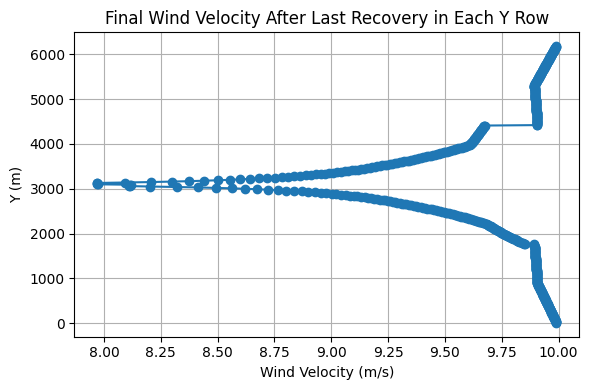

In [ ]:
resolution = 10
results = []

for y_idx in range(0, len(y_range), resolution):
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    # Identify all contiguous non-zero zones (deficit or recovery)
    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row)):
        if row[idx] != current_zone_type:
            # Zone ended
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})

            # Start new zone
            start_idx = idx
            current_zone_type = row[idx]

    # Handle last zone at end of row
    if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
        start_x = x_range[start_idx]
        end_x = x_range[len(row) - 1]
        zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
        results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})

"""
# Print the ordered zones
for result in results:
    print(f"At y = {result['y']}, {result['type']} zone starts at x = {result['start_x']} and ends at x = {result['end_x']}")
"""

# Initialize velocity profile collector
final_velocity_map = {}  # y -> final recovery uw

# Track current y to reset previous_recovery_end_uw
current_y = None

# Loop through results and process pairs of deficit + recovery
i = 0
while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x1 = zone1['start_x']
        x2 = zone1['end_x']
        x3 = zone2['end_x']
        y = zone1['y']

        # Reset Uh0 at the start of each new y-row
        if current_y != y:
            current_y = y
            previous_recovery_end_uw = U_h0

        x = np.linspace(x1, x3, int(x3 - x1) + 1)

        h1 = np.full_like(x, np.nan, dtype=float)
        h2 = np.full_like(x, np.nan, dtype=float)
        uw = np.full_like(x, previous_recovery_end_uw, dtype=float)  # Start from last recovery output

        # Compute h1 and h2
        h1[x > x1] = z_h + ((x[x > x1] - x1) / z0_WF) ** (4 / 5)
        h2[x > x2] = ((x[x > x2] - x2) / z0_WF) ** (4 / 5)

        # Deficit model
        idx1 = h1 >= z_h
        uw[idx1] = previous_recovery_end_uw * (np.log(h1[idx1] / z_0lo) * np.log(z_h / z0_WF)) / \
                                         (np.log(h1[idx1] / z0_WF) * np.log(z_h / z_0lo))

        # Recovery model
        idx2 = (x > x2) & (h2 >= z_h)
        uw[idx2] = previous_recovery_end_uw * (np.log(h1[idx2] / z_0lo) * np.log(h2[idx2] / z0_WF)) / \
                                            (np.log(h1[idx2] / z0_WF) * np.log(h2[idx2] / z_0lo))

        # Extract values robustly
        deficit_start_uw = uw[0]
        idx_x2 = np.argmin(np.abs(x - x2))
        deficit_end_uw = uw[idx_x2]
        recovery_start_uw = deficit_end_uw
        recovery_end_uw = uw[-1]

        # Update for next zone pair
        previous_recovery_end_uw = recovery_end_uw

        # Store final recovery value, overwriting previous ones for same y
        final_velocity_map[y] = recovery_end_uw

        """
        # Print info
        print(f"y = {y:.1f}")
        print(f"  Deficit:  x1 = {x1:.0f}, x2 = {x2:.0f} | Start = {deficit_start_uw:.2f} m/s, End = {deficit_end_uw:.2f} m/s")
        print(f"  Recovery: x2 = {x2:.0f}, x3 = {x3:.0f} | Start = {recovery_start_uw:.2f} m/s, End = {recovery_end_uw:.2f} m/s")
        """
        """
        # Plot (optional)
        plt.figure(figsize=(10, 4))
        plt.plot(x, uw, label=f"y = {y:.1f}")
        plt.axvline(x1, color='r', linestyle='--', label='Start Deficit')
        plt.axvline(x2, color='orange', linestyle='--', label='End Deficit / Start Recovery')
        plt.axvline(x3, color='g', linestyle='--', label='End Recovery')
        plt.xlabel('x (m)')
        plt.ylabel('Wind Speed (m/s)')
        plt.title(f"Wake Model for y = {y:.1f}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        """

        i += 2  # Skip ahead to next pair
    else:
        i += 1

# Convert final velocity map to sorted array and plot
final_velocity_profile = np.array(sorted(final_velocity_map.items()))

plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile[:, 1], final_velocity_profile[:, 0], marker='o')
plt.xlabel('Wind Velocity (m/s)')
plt.ylabel('Y (m)')
plt.title('Final Wind Velocity After Last Recovery in Each Y Row')
plt.grid(True)
plt.tight_layout()
plt.show()